# PLOS Capstone Progress 
### 2/6/18

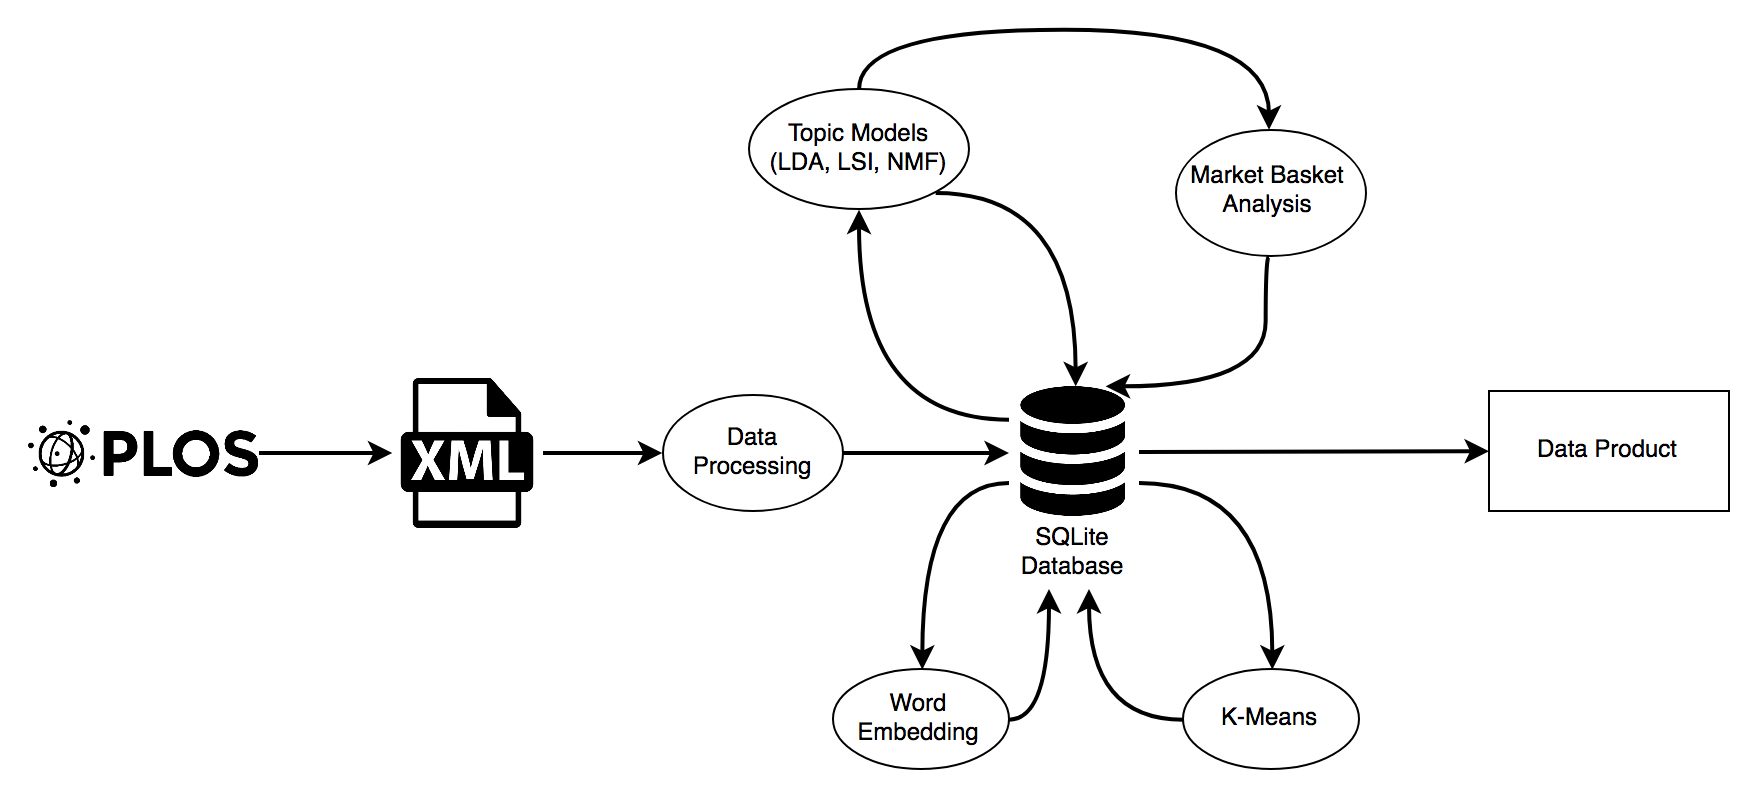

In [20]:
Image('dataflow.png')


## Preprocessing

In [47]:
import sqlite3
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from stop_words import get_stop_words
from tqdm import tqdm_notebook as tqdm
import gensim
from gensim import corpora, models, similarities
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
import gensim.models.doc2vec
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
from collections import OrderedDict
import multiprocessing
from collections import defaultdict
from nltk.tokenize.moses import MosesDetokenizer
from IPython.display import Image
import requests
from pprint import pprint
%matplotlib inline

In [4]:
conn = sqlite3.connect("/Users/jackprominski/Desktop/UVA DSI/Capstone/testDB.db")
df = pd.read_sql_query("select doi,title,abstract,body from trial_10000;", conn)

In [5]:
df['abstract']=df['abstract'].str.replace('\d+', '') # for digits
df['abstract']=df['abstract'].str.replace(r'(\b\w{1,2}\b)', '') # for words
df['abstract']=df['abstract'].str.replace('Background', '')
df['body']=df['body'].str.replace('Introduction', '')

In [6]:
df.head()

,doi,title,abstract,body
0,10.1371/journal.pone.0000100,['Factors Affecting Frequency Discrimination o...,Measuring perceptual judgments about stimuli w...,Many investigations of sensory processing are ...
1,10.1371/journal.pone.0000008,['Molecular Adaptation during Adaptive Radiati...,“Explosive” adaptive radiations islands remai...,The most dramatic “bursts” of adaptive radiati...
2,10.1371/journal.pone.0000061,['Self-Correcting Maps of Molecular Pathways'],Reliable and comprehensive maps molecular pat...,Scientific innovation often proceeds through a...
3,10.1371/journal.pone.0000094,['A Bayesian Network Driven Approach to Model ...,The transcriptional response exogenously supp...,Nitric oxide (NO·) is a critical mediator of t...
4,10.1371/journal.pone.0000011,['A Comparative Study on the Cost of New Antib...,Drug treatment becoming more expensive due t...,The investment of societies around the world o...


In [7]:
tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('en')
# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

In [8]:
texts = []
for i in tqdm(df['abstract']):
    #strip introduction from beginning of string
    raw = i.strip('Introduction')
    # clean and tokenize document string
    raw2 = raw.lower()
    tokens = tokenizer.tokenize(raw2)
    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    # strip numbers from tokens
    stripped_tokens = [i for i in stemmed_tokens if not i.isdigit()] 
    ## REMOVE SINGLE CHAR TOKENS?
    # add tokens to list
    texts.append(stripped_tokens)

In [9]:
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1]
         for text in texts]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [12]:
#print(dictionary.token2id)

In [25]:
#Save dictionary and corpus
corpora.MmCorpus.serialize('corpus.mm', corpus)
dictionary.save('dictionary.dict')

In [4]:
#Load saved files
corpus = corpora.MmCorpus('corpus.mm')
dictionary = corpora.Dictionary.load('dictionary.dict')

In [13]:
tfidf = models.TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

In [37]:
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=100)
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=100)

#lsi.save('/tmp/model.lsi') # same for tfidf, lda, ...
#lsi = models.LsiModel.load('/tmp/model.lsi')

/Users/jackprominski/anaconda/lib/python3.6/site-packages/gensim-3.2.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [82]:
lsi.save('model.lsi')
lda.save('model.lda')
#models.LsiModel.load('model.lsi')

In [14]:
# Load models
lsi = models.LsiModel.load('model.lsi')
lda = models.LdaModel.load('model.lda')

In [17]:
corpus_lsi = lsi[corpus_tfidf]
corpus_lda = lda[corpus_tfidf]

In [27]:
## How do we want to present this? Top topics for a given articles? 

print(lsi.print_topics(5))
print('---------')
print(lda.print_topics(5))

[(0, '0.502*"cell" + 0.229*"gene" + 0.224*"express" + 0.164*"activ" + 0.162*"protein" + 0.159*"use" + 0.144*"studi" + 0.112*"function" + 0.106*"result" + 0.102*"human"'), (1, '-0.768*"cell" + 0.263*"gene" + 0.139*"use" + 0.125*"studi" + 0.103*"associ" + 0.094*"sequenc" + 0.088*"differ" + 0.087*"genom" + 0.076*"protein" + 0.073*"data"'), (2, '0.663*"gene" + 0.374*"express" + -0.181*"infect" + -0.180*"hiv" + -0.126*"studi" + 0.124*"transcript" + 0.122*"regul" + -0.122*"use" + -0.110*"patient" + -0.096*"effect"'), (3, '-0.574*"protein" + -0.332*"activ" + 0.298*"gene" + 0.171*"hiv" + 0.161*"infect" + 0.159*"cell" + 0.154*"patient" + -0.148*"function" + -0.127*"bind" + -0.115*"interact"'), (4, '-0.418*"activ" + 0.333*"protein" + -0.288*"express" + 0.228*"cell" + 0.224*"sequenc" + -0.174*"mice" + -0.167*"increas" + -0.162*"induc" + 0.152*"genom" + 0.143*"use"')]
---------
[(170, '0.014*"deposit" + 0.014*"size" + 0.014*"pollen" + 0.013*"storag" + 0.013*"maiz" + 0.012*"bead" + 0.011*"meiotic" 

In [26]:
index = similarities.MatrixSimilarity(lsi[corpus])

In [30]:
index.save('similarity.index')

In [19]:
index = similarities.MatrixSimilarity.load('similarity.index')

## Querying

In [36]:
# better search -- based on semantic relationships instead of keyword
doc = input('Enter a search term: ')

vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow] # convert the query to LSI space
lsi_sims = sorted(enumerate(index[vec_lsi]), key=lambda item: -item[1])
simdocs_lsi = [x[0] for x in lsi_sims[1:10]]
df.loc[simdocs_lsi,'title']


## Don't truncate titles


Enter a search term: Cancer


7115    ['EpiCollect: Linking Smartphones to Web Appli...
7701    ['Fast and Flexible Selection with a Single Sw...
6848    ['Glutamate Excitotoxicity Inflicts Paranodal ...
9003      ['Dissociation of the Octameric Enolase from ']
7335    ['BtubA-BtubB Heterodimer Is an Essential Inte...
1871    ['Formation of Toxic Oligomeric α-Synuclein Sp...
3274    ['Chemical Addressability of Ultraviolet-Inact...
955     ['Phylodynamics of HIV-1 in Lymphoid and Non-L...
8923                        ['Crystal Structure of the ']
Name: title, dtype: object

In [110]:
# Most similar documents given doi
query_doi = input('Enter a DOI: ')
query_doc = df.loc[df['doi']==query_doi].index[0]
doc_bow = corpus[query_doc]

vec_lsi = lsi[doc_bow]
lsi_sims = sorted(enumerate(index[vec_lsi]), key=lambda item: -item[1])
simdocs_lsi = [x[0] for x in lsi_sims[1:10]]

vec_lda = lda[doc_bow]
lda_sims = sorted(enumerate(index[vec_lda]), key=lambda item: -item[1])
simdocs_lda = [x[0] for x in lda_sims[1:10]]

print('Target Document')
print(df.loc[query_doc,'title'])
print('LSI Most Similar Documents:')
print(df.loc[simdocs_lsi,'title'])
print('LDA Most Similar Documents:')
print(df.loc[simdocs_lda,'title'])


Target Document
['Molecular Adaptation during Adaptive Radiation in the Hawaiian Endemic Genus ']
LSI Most Similar Documents:
4697                         ['Molecular Adaptation of ']
439     ['Comparative Population Genetics of the Immun...
738     ['MHC Adaptive Divergence between Closely Rela...
2237    ['Duplicated Paralogous Genes Subject to Posit...
8492    ['Rhodopsin Molecular Evolution in Mammals Inh...
778     ['Patterns of Selection in Anti-Malarial Immun...
5806    ['Intense Habitat-Specific Fisheries-Induced S...
2205    ['Adaptive Evolution and Functional Redesign o...
8050    ['Wheat Domestication Accelerated Evolution an...
Name: title, dtype: object
LDA Most Similar Documents:
698     ['Regional Decline of Coral Cover in the Indo-...
8835    ['Marine Reserves Enhance the Recovery of Cora...
3398    ['Genetic Traces of Recent Long-Distance Dispe...
8037    ['Calcium-Dependent Increases in Protein Kinas...
7228    ['Behaviourally Mediated Phenotypic Selection ...
3476   

In [67]:
# terms from top topic of a given document

no1topic = lda.get_document_topics(corpus[query_doc], minimum_probability=.05)[0][0]
termprobs = lda.get_topic_terms(no1topic, topn=10)
termids = [x[0] for x in termprobs]
for x in termids:
    print(dictionary[x])

protein
structur
bind
domain
residu
site
fold
activ
substrat
use


## Word Embedding

In [40]:
documents = []
for i in range(0,len(texts)):
    documents.append(TaggedDocument(texts[i],df.loc[i,'doi']))

In [45]:
cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1

In [48]:
d2v_dbow = Doc2Vec(dm=0, size=100, negative=5, hs=0, min_count=2, workers=cores-1)
#d2v_dm = Doc2Vec(dm=1, dm_mean=1, size=100, window=10, negative=5, hs=0, min_count=2, workers=cores-1)

In [49]:
d2v_dbow.build_vocab(documents)
#d2v_dm.build_vocab(documents)

In [55]:
i = 0
for epoch in range(10):
    d2v_dbow.train(documents, total_examples=d2v_dbow.corpus_count, epochs=d2v_dbow.iter)
    d2v_dbow.alpha -= 0.002 # decrease the learning rate
    d2v_dbow.min_alpha = d2v_dbow.alpha # fix the learning rate, no deca
    d2v_dbow.train(documents, total_examples=d2v_dbow.corpus_count, epochs=d2v_dbow.iter)
    i+=
    print(i)

In [56]:
d2v_dbow.save('d2v_dbow.model')

In [58]:
docvec = d2v_dbow.docvecs[1]

In [68]:
d2v_dbow.wv.most_similar('cancer')

[('igi', 0.3754726052284241),
 ('katarina', 0.3638576567173004),
 ('resultsroutin', 0.36382755637168884),
 ('trophic', 0.34847038984298706),
 ('dim', 0.33813241124153137),
 ('phthalat', 0.3368508517742157),
 ('beekeep', 0.336805135011673),
 ('axi', 0.3332105278968811),
 ('immigr', 0.33125096559524536),
 ('lntb', 0.3274413049221039)]

In [124]:
model = d2v_dbow
doc_id = 1
sims = model.docvecs.most_similar(doc_id, topn=model.docvecs.count)  # get *all* similar documents
#print(u'TARGET (%d): «%s»\n' % (doc_id, ' '.join(documents[doc_id].words)))
print(df.loc[df['doi'] == documents[doc_id].tags,'title'])
print(df.loc[df['doi'] == documents[int(sims[0][0])].tags,'title'])

## SIMS? 


TARGET (1): «explos adapt radiat island remain one puzzl evolutionari phenomena rate phenotyp ecolog adapt extrem fast event suggest mani gene may fairli strong select howev evid adapt level protein code gene found suggest select may work mainli regulatori element report first evid posit select oper level protein code gene rapid adapt radiat studi molecular adapt hawaiian endem plant genu schiedea caryophyllacea includ close relat speci strike rang morpholog ecolog form vari rainforest woodi shrub grow desert like condit cliff given remark differ photosynthet perform schiedea speci differ habitat focus photosynthet rubisco enzym effici known limit step plant photosynthesi resultsw demonstr chloroplast rbcl gene encod larg subunit rubisco enzym evolv strong posit select schiedea adapt amino acid chang occur function import region rubisco interact rubisco chaperon promot maintain catalyt activ rubisco interestingli posit select act rbcl might caus favor cytotyp spread across sever schied

ValueError: invalid literal for int() with base 10: '.'

In [123]:
sims

[('0', 0.9892235994338989),
 ('.', 0.9887712597846985),
 ('o', 0.9662043452262878),
 ('n', 0.962530255317688),
 ('7', 0.9615259170532227),
 ('3', 0.9364324808120728),
 ('/', 0.9204038977622986),
 ('j', 0.91776442527771),
 ('u', 0.9147849678993225),
 ('a', 0.909738302230835),
 ('r', 0.9086992740631104),
 ('l', 0.9021143317222595),
 ('p', 0.8992642164230347),
 ('e', 0.884716272354126),
 ('9', 0.8756287693977356),
 ('6', 0.7195561528205872),
 ('4', 0.6581882238388062),
 ('5', 0.6239789724349976),
 ('2', 0.6054936051368713),
 ('8', 0.6011348962783813),
 ('-', 0.1590798944234848),
 ('f', 0.04081996902823448),
 ('d', 0.02323705516755581),
 ('t', -0.010946247726678848),
 ('i', -0.05797148495912552),
 ('b', -0.11568368226289749),
 ('c', -0.12854449450969696),
 (' ', -0.27158039808273315)]

In [115]:
for i in range(0,10):
    print(documents[i].tags)
    print(df.loc[df['doi'] == documents[i].tags,'title'])

10.1371/journal.pone.0000100
0    ['Factors Affecting Frequency Discrimination o...
Name: title, dtype: object
10.1371/journal.pone.0000008
1    ['Molecular Adaptation during Adaptive Radiati...
Name: title, dtype: object
10.1371/journal.pone.0000061
2    ['Self-Correcting Maps of Molecular Pathways']
Name: title, dtype: object
10.1371/journal.pone.0000094
3    ['A Bayesian Network Driven Approach to Model ...
Name: title, dtype: object
10.1371/journal.pone.0000011
4    ['A Comparative Study on the Cost of New Antib...
Name: title, dtype: object
10.1371/journal.pone.0000131
5    ["Rho Kinase's Role in Myosin Recruitment to t...
Name: title, dtype: object
10.1371/journal.pone.0000077
6    ['GATA Transcription Factor Required for Immun...
Name: title, dtype: object
10.1371/journal.pone.0000027
7    ['Spatial Control of Rabies on Heterogeneous L...
Name: title, dtype: object
10.1371/journal.pone.0000080
8    ['Cross Species Association Examination of UCN...
Name: title, dtype: object
10.1